In [9]:
"""
Wind-turbine sizing for CBS power demand (10–20 Jan 2025)
=========================================================
* Turbine model  : AWM-1500D  (1.50 kW rated @ 12.5 m s⁻¹)
* Design targets : worst-day coverage  **and**  average-day coverage
* Weather file   : hourly wind speeds (km h⁻¹) for the same period
* Demand file    : daily CBS load (kWh day⁻¹)
"""

import numpy as np
import pandas as pd
import math

# -------------------------------------------------------------------
# 1 · Load DAILY CBS demand (kWh/day) -------------------------------
# -------------------------------------------------------------------
demand_path = (
    "Data/Exp/Daily_Power_Demand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv"
)
demand_df = pd.read_csv(demand_path, parse_dates=["Date"])
max_load_kWh = demand_df["CBSs_kWh/Day"].max()     # 135.91 kWh (17 Jan 2025)

# -------------------------------------------------------------------
# 2 · Load HOURLY wind data, convert km h⁻¹ → m s⁻¹ -----------------
# -------------------------------------------------------------------
weather_path = "Data/Exp/ProcessedData_Wollongong_Weather__10_20_Jan_2025.csv"
df = pd.read_csv(weather_path, parse_dates=["Timestamp"])
df["Wind_m/s"] = df["Wind_km_h"] / 3.6              # keep Wind_km_h if needed

# -------------------------------------------------------------------
# 3 · AWM-1500D physical and control parameters ---------------------
# -------------------------------------------------------------------
rho         = 1.225             # air density (kg m⁻³) @15 °C, sea level
Cp          = 0.59              # Power coefficient
A           = 1.77              # swept area   (m²)
P_rated     = 1500              # rated power (W)
V_rated     = 12.5              # rated wind speed (m s⁻¹)
V_cut_in    = 3.0               # turbine starts here (m s⁻¹)
V_cut_out   = 14.0              # turbine furl/brakes here (m s⁻¹)


# # Optional
# P_mech_rated    = 700                   # mechanical power at V_rated (W)
# R               = (A / np.pi) ** 0.5    # rotor radius (m)




# -------------------------------------------------------------------
# 4 · Per-turbine power time-series (kW), with cut-in/out enforced ---
# -------------------------------------------------------------------
df["P_avail_W_m2"] = 0.5 * rho * df["Wind_m/s"]**3
df["P_turbine_kW"] = (Cp * A * df["P_avail_W_m2"]) / 1_000

mask_off = (df["Wind_m/s"] < V_cut_in) | (df["Wind_m/s"] > V_cut_out)
df.loc[mask_off, "P_turbine_kW"] = 0.0

# -------------------------------------------------------------------
# 5 · Aggregate to DAILY energy per single turbine (kWh) ------------
# -------------------------------------------------------------------
df["Date"] = df["Timestamp"].dt.floor("D")
daily_E = df.groupby("Date")["P_turbine_kW"].sum()  # 1-h interval ⇒ kWh

E_min  = daily_E.min()      # calmest day  (kWh)
E_avg  = daily_E.mean()     # mean energy  (kWh)

# -------------------------------------------------------------------
# 6 · Turbine count required to meet CBS load -----------------------
#     – n_worst : guarantees coverage even on calmest day
#     – n_avg   : meets load on an average day (storage/back-up needed)
# -------------------------------------------------------------------
n_worst = math.ceil(max_load_kWh / E_min)
n_avg   = math.ceil(max_load_kWh / E_avg)

# -------------------------------------------------------------------
# 7 · Report ---------------------------------------------------------
# -------------------------------------------------------------------
print("\n=== CBS Daily Demand (kWh/day) ===============================")
print(demand_df[["Date", "CBSs_kWh/Day"]].to_string(index=False))
print(f"\nPeak daily load : {max_load_kWh:.2f} kWh\n")

print("=== AWM-1500D Derived Rotor Geometry =========================")
print(f"Swept area A    : {A:.2f} m²")
# print(f"Rotor radius R  : {R:.2f} m\n")

print("=== Single-Turbine Energy over Study Window ==================")
print(daily_E.to_string())
print(f"\nWorst-day energy: {E_min:.2f} kWh")
print(f"Average energy : {E_avg:.2f} kWh\n")

print("=== Turbine Sizing Results ===================================")
print(f"Turbines required (worst-day sizing)  : {n_worst}")
print(f"Turbines required (average-day sizing): {n_avg}")


=== CBS Daily Demand (kWh/day) ===============================
      Date  CBSs_kWh/Day
2025-01-10    115.436912
2025-01-11    115.567961
2025-01-12    115.906767
2025-01-13    115.939675
2025-01-14    115.663358
2025-01-15    124.283600
2025-01-16    135.607501
2025-01-17    135.906610
2025-01-18    135.580528
2025-01-19    122.633538
2025-01-20    123.354338

Peak daily load : 135.91 kWh

=== AWM-1500D Derived Rotor Geometry =========================
Swept area A    : 1.77 m²
=== Single-Turbine Energy over Study Window ==================
Date
2025-01-10     0.712802
2025-01-11     0.483098
2025-01-12     4.005553
2025-01-13     0.952130
2025-01-14     1.240003
2025-01-15     2.870030
2025-01-16    12.405105
2025-01-17    11.100270
2025-01-18    17.362404
2025-01-19    14.534723
2025-01-20     0.711623

Worst-day energy: 0.48 kWh
Average energy : 6.03 kWh

=== Turbine Sizing Results ===================================
Turbines required (worst-day sizing)  : 282
Turbines required (ave

In [10]:
"""
Wind-Turbine Power Generation to Meet Cellular Base-Station (CBS) Load  
Study period : 10 – 20 January 2025
=====================================================================

Turbine model  : AWM-1500D (1.50 kW rated at 12.5 m s⁻¹)  
Design targets : Cover both the **worst-day** peak and the **average-day** energy demand  
Weather data   : Hourly wind speed (km h⁻¹) for the same period  
Load profile   : Daily CBS energy demand (kWh day⁻¹)
"""

import numpy as np
import pandas as pd
import math

# ------------------------------------------------------------------
# 1 · Import daily CBS demand data (kWh day⁻¹) ----------------------
# ------------------------------------------------------------------
demand_path = (
    "Data/Exp/Daily_Power_Demand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv"
)
demand_df = pd.read_csv(demand_path, parse_dates=["Date"])
max_load_kWh = demand_df["CBSs_kWh/Day"].max()      # 135.91 kWh on 17 Jan 2025

# ------------------------------------------------------------------
# 2 · Import hourly wind data and convert km h⁻¹ → m s⁻¹ ------------
# ------------------------------------------------------------------
weather_path = "Data/Exp/ProcessedData_Wollongong_Weather__10_20_Jan_2025.csv"
df = pd.read_csv(weather_path, parse_dates=["Timestamp"])
df["Wind_m/s"] = df["Wind_km_h"] / 3.6              # retain Wind_km_h for reference

# ------------------------------------------------------------------
# 3 · Define AWM-1500D physical and control parameters -------------
# ------------------------------------------------------------------
rho         = 1.225   # Air density (kg m⁻³) at 15 °C, sea level
Cp          = 0.59    # Power coefficient (≈ Betz limit)
A           = 1.77    # Rotor swept area (m²)
P_rated     = 1500    # Rated electrical power (W)
V_rated     = 12.5    # Rated wind speed (m s⁻¹)
V_cut_in    = 3.0     # Start-up wind speed (m s⁻¹)
V_cut_out   = 14.0    # Cut-out (furling/braking) speed (m s⁻¹)
WT_Qty      = 23      # Number of turbines determined by sizing study

# ------------------------------------------------------------------
# 4 · Compute per-turbine power time-series (kW) with cut-in/out ----
# ------------------------------------------------------------------
df["P_avail_W_m2"] = 0.5 * rho * df["Wind_m/s"]**3          # Specific wind power (W m⁻²)
df["WT_kW"] = (WT_Qty * Cp * A * df["P_avail_W_m2"]) / 1_000

# Force zero output when wind is below cut-in or above cut-out speed
mask_off = (df["Wind_m/s"] < V_cut_in) | (df["Wind_m/s"] > V_cut_out)
df.loc[mask_off, "WT_kW"] = 0.0

# ------------------------------------------------------------------
# 5 · Save the relevant columns to CSV -----------------------------
# ------------------------------------------------------------------
output_cols = ["Timestamp", "Wind_km_h", "Wind_m/s", "WT_kW"]
df = df[output_cols].copy()
df[output_cols].to_csv(
    "Data/Test/PowerGeneration_Wind__10_20_Jan_2025.csv",
    index=False
)
df

,Timestamp,Wind_km_h,Wind_m/s,WT_kW
0,2025-01-10 00:00:00,9,2.500000,0.000000
1,2025-01-10 01:00:00,9,2.500000,0.000000
2,2025-01-10 02:00:00,11,3.055556,0.419691
3,2025-01-10 03:00:00,7,1.944444,0.000000
4,2025-01-10 04:00:00,13,3.611111,0.692758
...,...,...,...,...
250,2025-01-20 19:00:00,11,3.055556,0.419691
251,2025-01-20 20:00:00,9,2.500000,0.000000
252,2025-01-20 21:00:00,0,0.000000,0.000000
253,2025-01-20 22:00:00,0,0.000000,0.000000


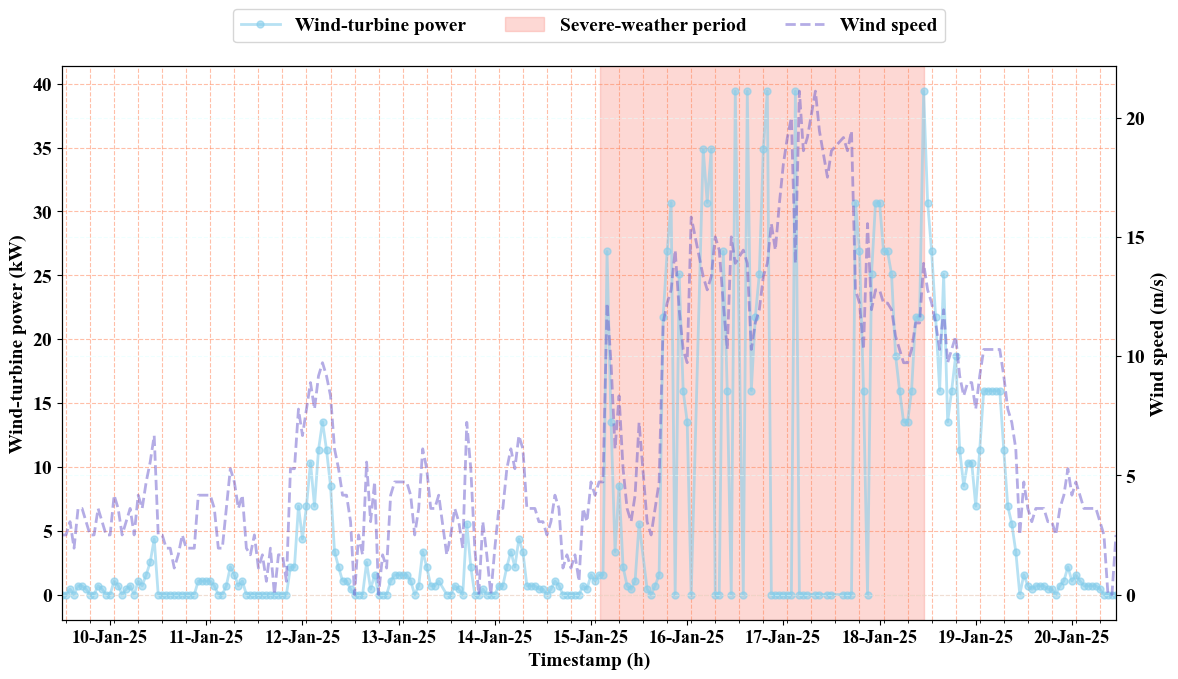

In [11]:
"""
Wollongong wind-farm profile, 10–20 Jan 2025
============================================
• Primary y-axis  : Firm wind-turbine power output  (WT_kW)
• Secondary y-axis: Measured hub-height wind speed  (km h⁻¹)
• Shaded window   : Severe-weather period flagged by the user
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ------------------------------------------------------------------
# 1 ·  Matplotlib defaults (Times New Roman, bold, 14 pt)
# ------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]   = 14
plt.rcParams["font.weight"] = "bold"

# ------------------------------------------------------------------
# 2 ·  Create figure and primary axis
# ------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(12, 7))

# -- 2a ·  Plot WIND-TURBINE POWER on primary y-axis ----------------
ax1.plot(
    df["Timestamp"],
    df["WT_kW"],
    color="skyblue",
    linewidth=2,
    marker="o",
    markersize=5,
    alpha=0.6,
    label="Wind-turbine power",
)

ax1.set_ylabel("Wind-turbine power (kW)", fontweight="bold")

# ------------------------------------------------------------------
# 3 ·  Secondary axis for WIND SPEED
# ------------------------------------------------------------------
ax2 = ax1.twinx()

ax2.plot(
    df["Timestamp"],
    # df["Wind_km_h"],
    df["Wind_m/s"],
    color="slateblue",
    linewidth=2,
    linestyle="--",
    markersize=3,
    alpha=0.5,
    label="Wind speed",
)

# ax2.set_ylabel("Wind speed (km/h)", fontweight="bold")
ax2.set_ylabel("Wind speed (m/s)", fontweight="bold")

# ------------------------------------------------------------------
# 4 ·  Axes styling: ticks, grids, date limits
# ------------------------------------------------------------------
ax1.set_xlabel("Timestamp (h)", fontweight="bold")

# Major ticks → one per day (shown at noon)
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))

# Minor ticks → every 6 h
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# Vertical grid at every minor tick; horizontal grid at y-major ticks
ax1.grid(which="minor", axis="x", linestyle="--", color="coral", alpha=0.5)
ax1.grid(which="major", axis="y", linestyle="--", color="coral", alpha=0.5)
ax2.grid(which="major", axis="y", linestyle="--", color="lightcyan", alpha=0.5)

# X-axis window 10 Jan 00:00 → 20 Jan 23:00
ax1.set_xlim(pd.Timestamp("2025-01-10 00:00"),
             pd.Timestamp("2025-01-20 23:00"))
ax1.tick_params(axis="x", rotation=0, labelsize=13)

# ------------------------------------------------------------------
# 5 ·  Highlight severe-weather window                             --
# ------------------------------------------------------------------
ax1.axvspan(
    pd.Timestamp("2025-01-15 14:20"),
    pd.Timestamp("2025-01-18 22:59"),
    color="salmon",
    alpha=0.3,
    label="Severe-weather period",
)

# ------------------------------------------------------------------
# 6 ·  Combine legends from both axes (plus shaded patch) ----------
# ------------------------------------------------------------------
lines,  labels  = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines + lines2,
    labels + labels2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,
    frameon=True,
)

# ------------------------------------------------------------------
# 7 ·  Export figure ----------------------------------------------
# ------------------------------------------------------------------
plt.tight_layout()
plt.savefig(
    "Figures/Wollongong_WindPower_10_20_Jan_2025.png",
    dpi=600,
    bbox_inches="tight",
)
# plt.show()   # uncomment for interactive display